In [1]:
from typing import Dict, List, Tuple

import empyrical as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from SignalMaker.qrs import QRSCreator
from src import (calc_signal_bins_corr, concat_ohlc_vs_signal,
                 concat_signal_vs_forward_returns)
from src.plotting import (displot_signal, displot_signal_vs_forward_returns,
                          plot_cumulative_return)

# 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

d:\anaconda3\envs\qlib_env\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# 信号构建

信号并非用支撑位与阻力位作突破或反转交易的阈值，而是更关注市场参与者们对于阻力位与支撑位的定位一致性。因此一个简单想法是利用类似$\frac{\delta(high)}{\delta(low)}$的值来描述支撑位与阻力位的相对强度，即最低价每变动 1 的时候，最高价变动的幅度。实际上， $\frac{\delta(high)}{\delta(low)}$是连接高低价格平面上的两点 (low[0], high[0]) 与 (low[1], high[1]) 的斜率。由于市场量价本身噪音的存在，仅计算两点得到的斜率数据包含了太多的噪音。我们考虑通过最近 N 个 (low, high) 的数据点来得到信噪相对较高的最高最低价相对变化程度。
使用线性回归，建立如下般最高价与最低价之间的线性模型：
$$hight_{t}=\alpha+\beta*low_{t}+\epsilon$$

式中拟合出的$\beta$值即是用以刻画支撑与阻力强度对比的代理指标，表明最近一段时期， 最低价每波动 1 个点位，最高价相应会波动$\beta$个点位。因此，$\beta$越大，表明支撑强度相 比阻力强度越显著，市场越容易上行，牛市中大概率对应后市加速上涨的走势，熊市中 则对应后市止跌企稳的走势；同理，$\beta$越小，表明阻力相对支撑的强度更甚，在牛市中 可能预示着即将见顶，在熊市中则对应后市大概率加速深跌。

QRS指标的构建中信号项(signal)部分：$zscore(\beta)$，惩罚项(Regulation)部分$R^{2}$ 。实际上在普通线性回归里，$\beta$有简单的解析解：$\beta = \frac{std(y)}{std(x)} ∗ 𝑐𝑜𝑟𝑟(y, x)$；而 $R^{2}$则 为：$R^{2} = corr(y, x)^{2}$ 。由此我们可以发现，整个指标实际上可以仅由三个简单数据决定： 最高价序列的波动率、最低价序列的波动率、最高级与最低价的相关系数。而原始指标 值可以转写为：

$$zscore(\frac{std(y)}{std(x)}*corr(y,x))*corr(y,x)^{2}$$

其中 y 是最高价序列，x 是最低价序列。

In [2]:
# 读取数据
daily: pd.DataFrame = pd.read_parquet("data/daily.parquet")

pivot_table: pd.DataFrame = pd.pivot_table(
    daily, index="trade_date", columns="code", values=["high", "low","open","close"]
)

high_df: pd.DataFrame = pivot_table["high"]
low_df: pd.DataFrame = pivot_table["low"]
close_df:pd.DataFrame = pivot_table["close"]

# t日信号,t+1日买入,则t日收益为(t+2/t+1)-1,所有shift=-8
forward_returns:pd.DataFrame = close_df.pct_change(10).shift(-8)

In [3]:
# 数据中的标的
daily['code'].unique().tolist()

['000016.SH', '000852.SH', '000905.SH', '000001.SH', '000300.SH', '000985.CSI']

检查历史上不同β值下指数后续的预期收益率。以N=18计算的β为例，我们以 0.01 为 间隔将历史β值划分成不同子样本，计算每个子样本内β值对应的沪深300、中证500等指数10日后收益率的均值，作为该β取值范围对应的未来指数预期收益率。

In [4]:
qrs:QRSCreator = QRSCreator(low_df, high_df)
signal_df:pd.DataFrame = qrs.fit(18,600)

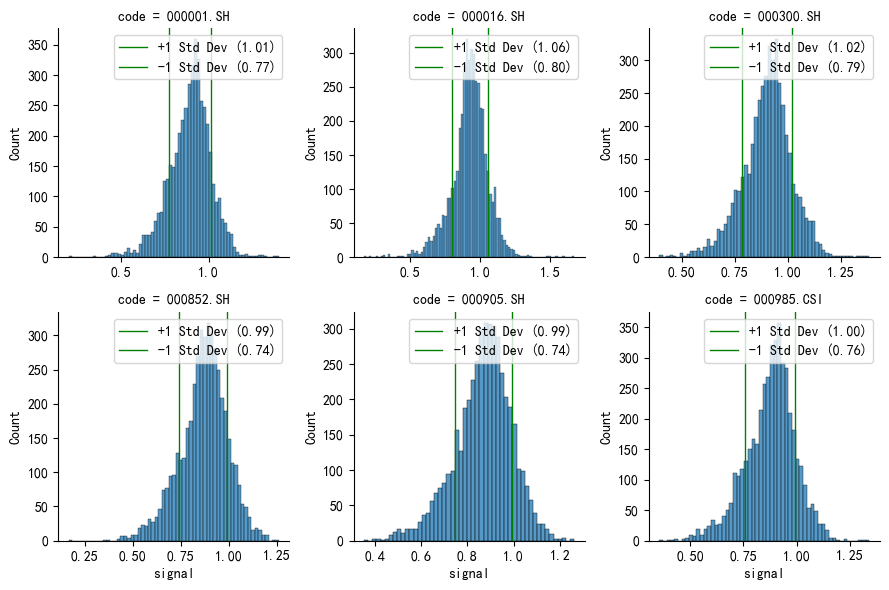

In [5]:
displot_signal(qrs.beta);

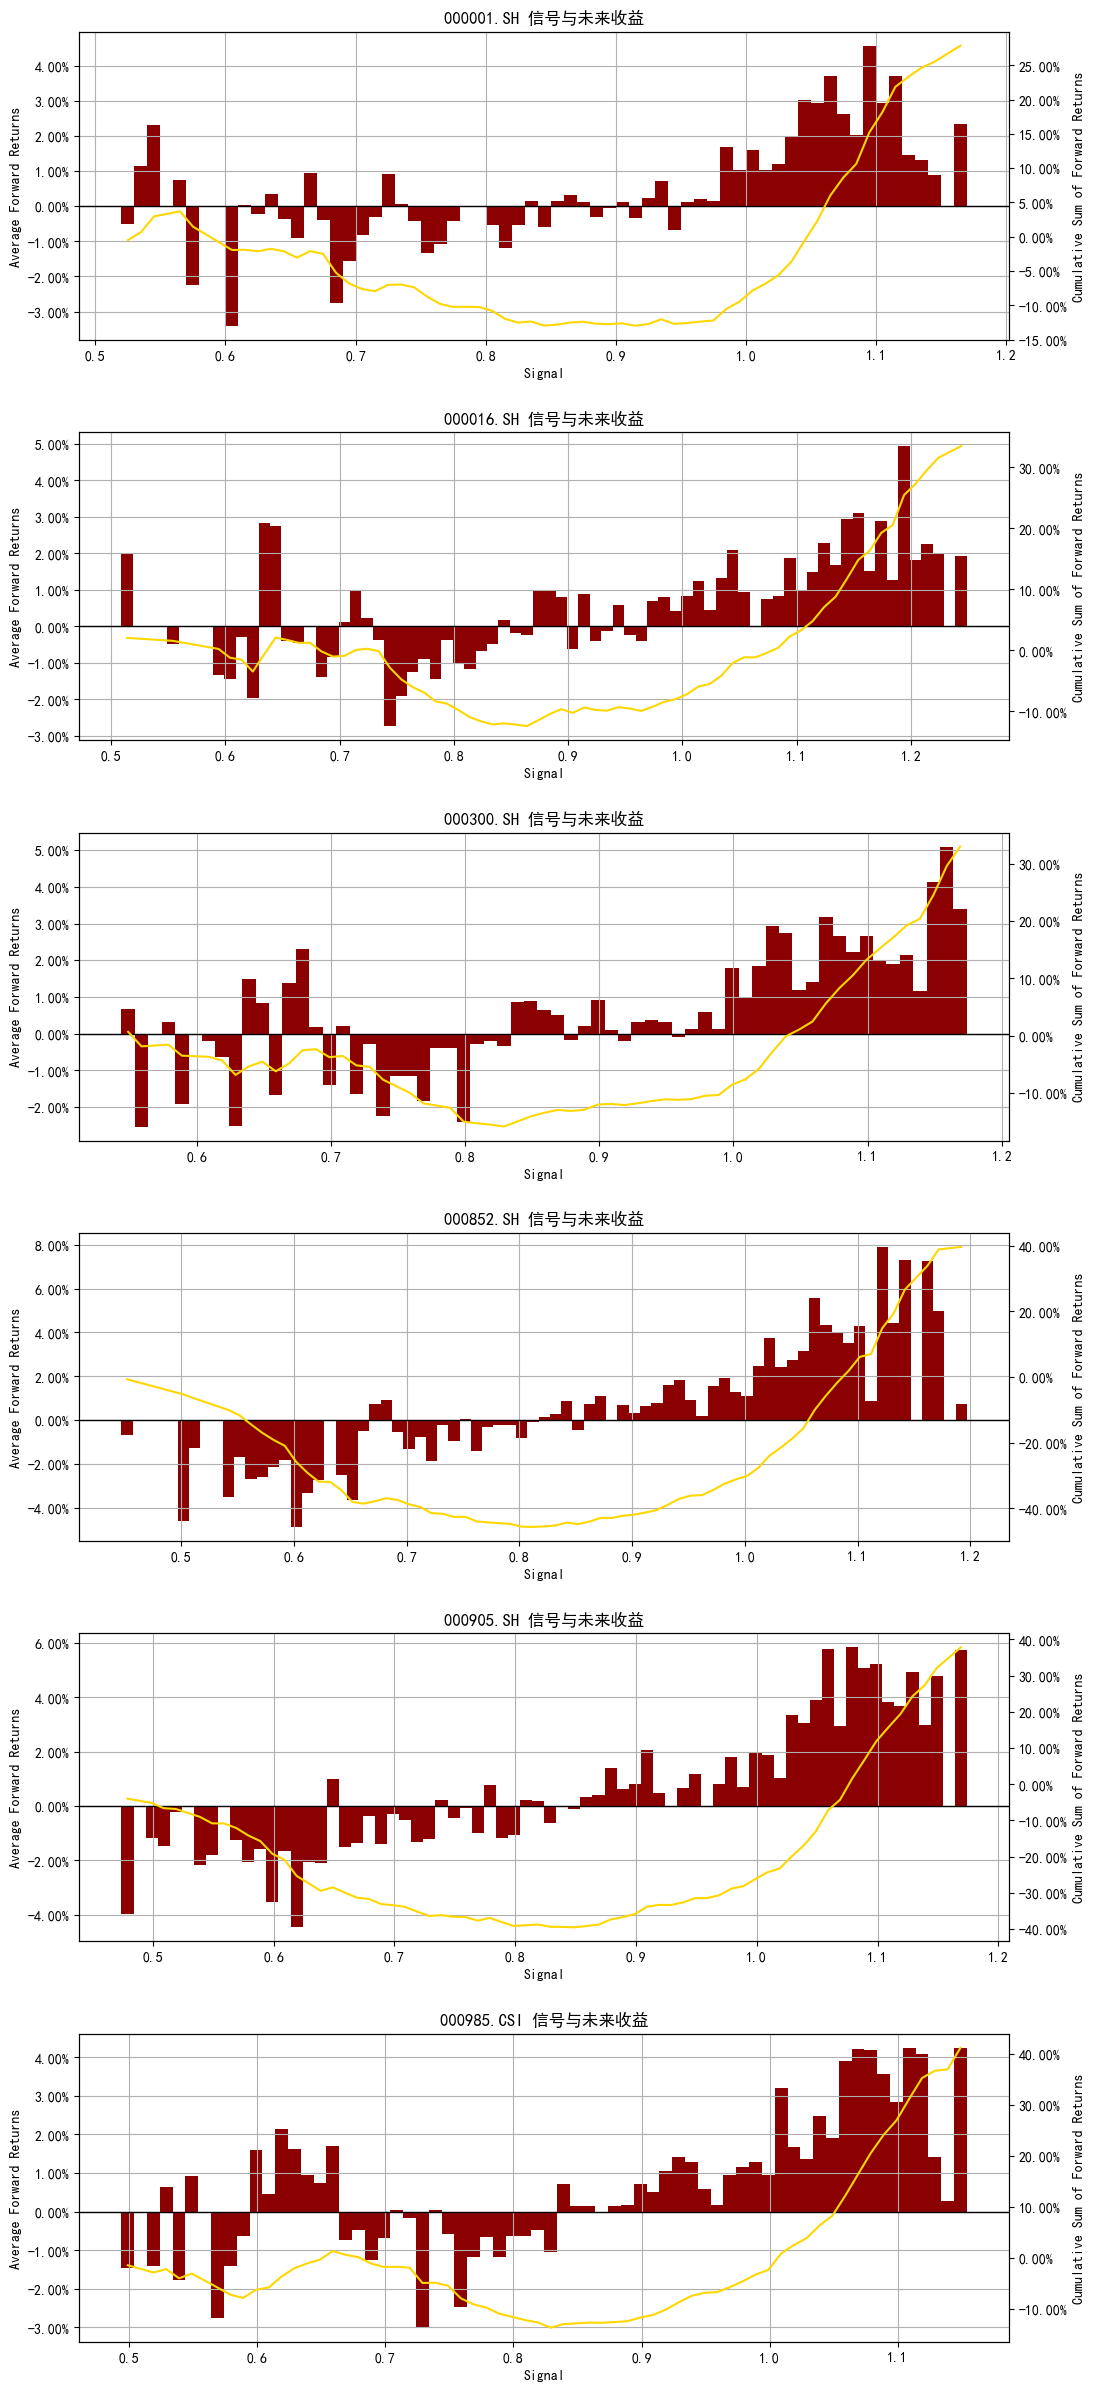

In [6]:
signal_and_forward_return: pd.DataFrame = concat_signal_vs_forward_returns(
    qrs.beta, forward_returns
)
# 只统计区间样本数量大于5个的区间
displot_signal_vs_forward_returns(signal_and_forward_return, step=0.01, threshold=5);

β取值与沪深 300 指数 10 天后预期收益率的相关系数为0.56(研报中为0.25)。如果考虑到有些β的取值区间内样本数太少，我们可以只统计样本数量至少为5个的取值区间。在限定了样本数量后，β取值与沪深 300 指数 10 天后预期收益率的相关系数为0.57(研报中为0.63)。

In [7]:
# 各个指数与未来10日收益的相关系数
calc_signal_bins_corr(signal_and_forward_return, step=0.01)

code
000001.SH     0.633761
000016.SH     0.611353
000300.SH     0.701592
000852.SH     0.853993
000905.SH     0.871730
000985.CSI    0.660092
dtype: float64

In [8]:
# 各个指数与未来10日收益的相关系数(排除区间样本低于5的)
calc_signal_bins_corr(signal_and_forward_return, step=0.01, threshold=5)

code
000001.SH     0.563629
000016.SH     0.358544
000300.SH     0.489586
000852.SH     0.807594
000905.SH     0.700619
000985.CSI    0.663143
dtype: float64

在确认了构建的技术指标有一定预测涨跌的能力之后，为了能利用它来构建量化择时策略，我们接下来还需要明确定义，指标值多大才算大，多小才算小。因此，需要对指标 值进行标准化处理。标准化处理的方式一般有两种，正态标准化或分位数。从效果上来说，这两种方式都能达到标准化目的，效果大同小异。

本例中将采取正态标准化计算β的 z_score 值，标准化后能得到更加直观的指标值大小。 同时需要意识到，在用线性回归模型计算β时，无论最高价与最低价序列是否有较好的 线性关系，都能得到一个β值。但当最高价与最低价并无明显线性关系的时候，线性回 归模型的有效性假设得不到满足，此时计算出的$\beta$值实际上是一个并无法有效表征择时 逻辑的噪音值，如果这样的噪音被当作择时信号，那么技术指标的有效性就会大打折扣。 因此我们希望在指标中加入一个惩罚机制，使得大部分的噪音指标能被过滤掉。在本次 个例中，β值的有效性与线性回归拟合效果有明显正相关，因此可以用回归模型的决定系数$R^{2}$刻画技术指标的有效性。

**利用 QRS 指标构建择时策略，测试其择时能力。择时模型策略为**

1. 计算 QRS 指标值；
2. 若指标值向上穿过开仓阈值 S，则买入持有；
3. 若指标值向下穿过平仓阈值-S，则卖出平仓；
4. 其余时候维持仓位不变。
5. 
我们选取（N=18, M=600, S=0.7）作为模型参数

In [9]:
from backtrader_utils.bt_template import run_template_strategy
from strategy.rsrs_strategy import RSRSStrategy

from src.performance import multi_asset_show_perf_stats,multi_strategy_show_trade_stats

In [10]:
ohlc_and_signal:pd.DataFrame = concat_ohlc_vs_signal(daily,signal_df)
ohlc_and_signal['upperbound'] = 0.7
ohlc_and_signal['lowerbound'] = -0.7

In [11]:
multi_asset_dict: Dict = {
    code: run_template_strategy(
        ohlc_and_signal,
        code,
        RSRSStrategy,
        strategy_kwargs={"verbose": False, "hold_num": 1},
    )
    for code in ohlc_and_signal['code'].unique()
}

2024-10-29 16:42:03.474 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:03.483 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！
2024-10-29 16:42:03.900 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:03.908 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！
2024-10-29 16:42:04.394 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:04.402 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！
2024-10-29 16:42:04.816 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:04.826 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！
2024-10-29 16:42:05.245 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:05.253 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！
2024-10-29 16:42:05.666 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:05.674 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！


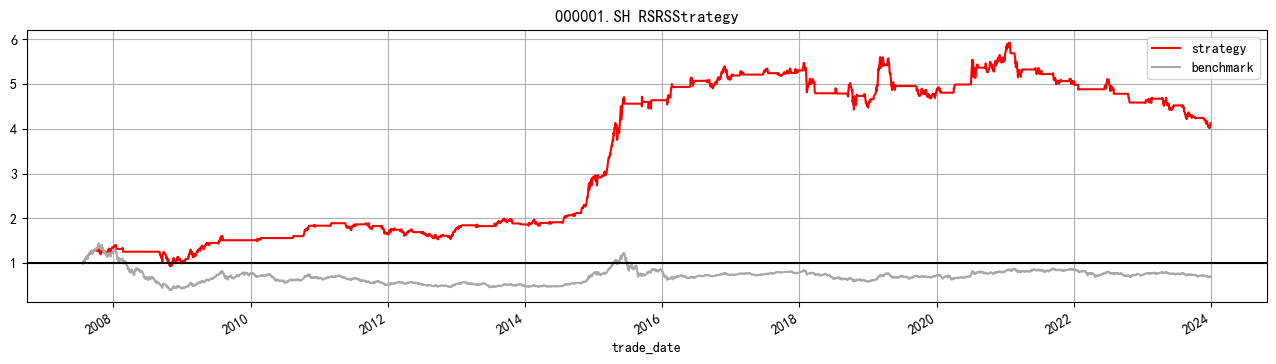

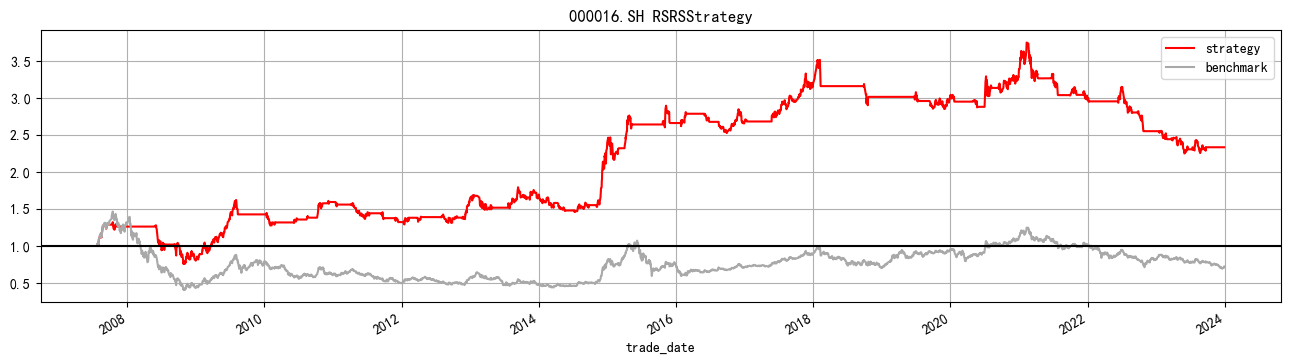

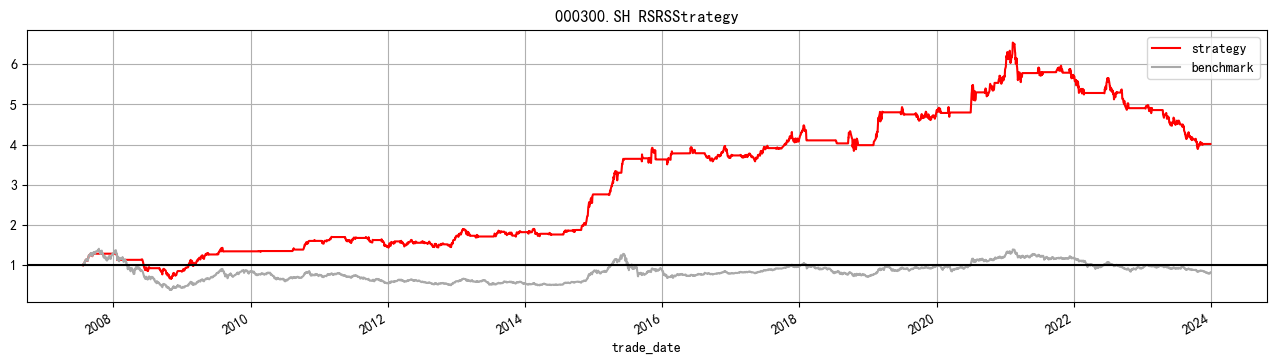

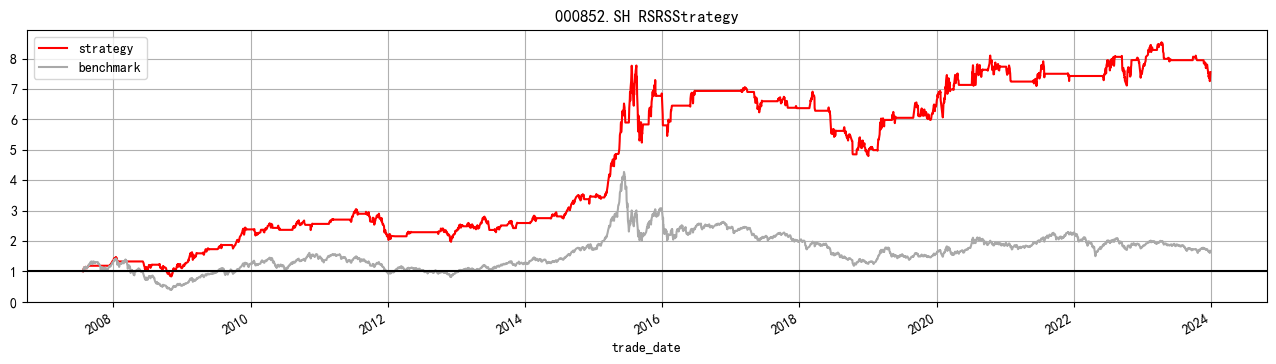

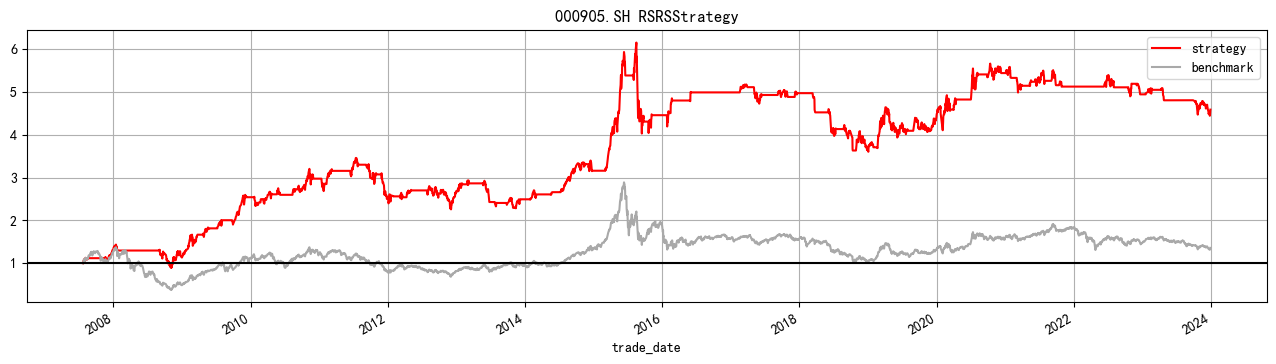

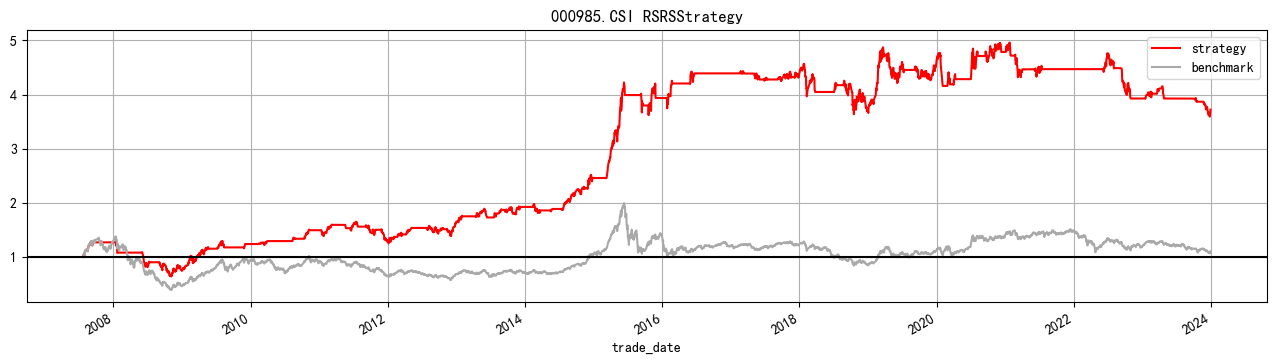

In [12]:
for code, strat in multi_asset_dict.items():
    plot_cumulative_return(
        strat,
        ohlc_and_signal.query("code==@code")["close"],
        title=f"{code} RSRSStrategy",
    )

In [13]:
multi_asset_show_perf_stats(multi_asset_dict,ohlc_and_signal)

d:\anaconda3\envs\qlib_env\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
d:\anaconda3\envs\qlib_env\lib\site-packages\pyfolio\plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():
d:\anaconda3\envs\qlib_env\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
d:\anaconda3\envs\qlib_env\lib\site-packages\pyfolio\plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():
d:\anaconda3\envs\qlib_env\lib\site-packages

,000001.SH,000016.SH,000300.SH,000852.SH,000905.SH,000985.CSI
,Backtest,Backtest,Backtest,Backtest,Backtest,Backtest
Annual return,9.3%,5.5%,9.2%,13.6%,10.1%,8.6%
Cumulative returns,312.9%,133.7%,301.8%,655.9%,359.1%,272.1%
Annual volatility,15.0%,17.2%,16.4%,21.1%,19.7%,17.3%
Sharpe ratio,0.672028,0.396981,0.616707,0.709758,0.58667,0.565063
Calmar ratio,0.278231,0.128166,0.188604,0.311494,0.24318,0.171835
Stability,0.809051,0.757938,0.894658,0.86628,0.750806,0.829811
Max drawdown,-33.6%,-42.9%,-48.6%,-43.6%,-41.4%,-50.2%
Omega ratio,1.199244,1.112519,1.175445,1.197276,1.16147,1.162538
Sortino ratio,1.000513,0.58719,0.916014,0.984851,0.814014,0.802119


# 对惩罚项进行改造

首先，从结构简单的惩罚项这个角度，剖析构造的改进可能性。


惩罚力度如何控制比较好呢？**虽然理论上一个相关系数的取值是可正可负的，但在现实 中当 𝑐𝑜𝑟𝑟(ℎ𝑖𝑔ℎ, 𝑙𝑜𝑤) 的计算窗口在 10 天以上时，几乎不会出现负值**，那么我们在以 𝑐𝑜𝑟𝑟(ℎ𝑖𝑔ℎ, 𝑙𝑜𝑤) 为基础构建惩罚项时，一定要取 2 次方么，如果 1 次方会如何，3 次方 会如何，甚至 0 次方会是什么结果？我们分别测试以 𝑐𝑜𝑟𝑟(ℎ𝑖𝑔ℎ, 𝑙𝑜𝑤) 为基但幂数不同 的构造下，指标择时的效果。

In [14]:
target_code: str = "000300.SH"
fields: List[str] = ["code","open", "high", "low", "close", "volume"]
hs300_df: pd.DataFrame = daily.query("code==@target_code")[fields].copy()
qrs: QRSCreator = QRSCreator(low_df[target_code], high_df[target_code])
single_qrs: pd.DataFrame = qrs.fit(18, 600, n=2)

In [15]:
# 单一计算与矩阵计算有差异
np.array_equal(signal_df[target_code].values, single_qrs["Signal"].values)

False

In [16]:
# 两者的差异很小
np.allclose(
    signal_df[target_code].values, single_qrs["Signal"].values, rtol=1e-10, atol=1e-10
)

True

In [17]:
hs300_df['signal'] = single_qrs['Signal']
hs300_df['upperbound'] = 0.7
hs300_df['lowerbound'] = -0.7

In [18]:
multi_regulation_dict: Dict = {}
for lag in [0, 1, 2, 3]:
    single_qrs: pd.DataFrame = qrs.fit(18, 600, n=lag)
    hs300_df["signal"] = single_qrs["Signal"]
    hs300_df["upperbound"] = 0.7
    hs300_df["lowerbound"] = -0.7

    multi_regulation_dict[f"R{lag:d}"] = run_template_strategy(
        hs300_df.dropna(),
        target_code,
        RSRSStrategy,
        strategy_kwargs={"verbose": False, "hold_num": 1},
    )

2024-10-29 16:42:08.494 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:08.504 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！
2024-10-29 16:42:09.411 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:09.420 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！
2024-10-29 16:42:10.305 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:10.314 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！
2024-10-29 16:42:11.203 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:11.212 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！


从结果可以看出当 QRS 指标构造中的惩罚项为 R0 次方或 R1 次方时，模型年化收益为 18%， 交易笔数在 60 次以上，胜率在 53%-56%左右；而当惩罚项力度放大，为 R2 次方或 R3 次方时，模型年化收益为 16%，交易笔数少于 60 次，胜率则在 54%-58%左右。

In [19]:
multi_strategy_show_trade_stats(multi_regulation_dict)

,R0,R1,R2,R3
,Trade Stats,Trade Stats,Trade Stats,Trade Stats
Annual return,10.72%,10.71%,9.16%,9.64%
Sharpe ratio,0.70,0.70,0.62,0.64
Max drawdown,47.87%,47.87%,48.55%,47.67%
Trade Num,68,62,56,50
Win Rate,55.88%,53.23%,53.57%,58.00%
Win Loss Ratio,1.73,1.85,1.78,1.66


这里与逻辑相违背的一点是，为什么指标在没有惩罚项（R0 次方）的时候，择时结果比 有惩罚项时还要好？我们发现造成这一现象的原因很可能源于我们没有对惩罚项的量级 进行调整。**由于𝑐𝑜𝑟𝑟(ℎ𝑖𝑔ℎ, 𝑙𝑜𝑤) 本身是一个小于 1 的数字，因此幂数越大，最终的惩罚 项的量级就越小，在维持开平仓阈值不变的情况下，量级变小的惩罚项实际上除了更大 地过滤噪音，实际上也过度过滤了有效信息**。

交易笔数统计数据也验证了这一点，随着 𝑐𝑜𝑟𝑟(ℎ𝑖𝑔ℎ, 𝑙𝑜𝑤)的次方数不断上升，全样本内的交易笔数从68大幅减少至50次。因此 如果希望能有效对比不同幂数下惩罚项对指标择时能力的影响，对惩罚项进行量级归一 是很有必要的。我们对指标构建的方式作如下改变：

$$指标值 = 信号项 *（惩罚项 / 惩罚项滚动时序样本内均值）$$

在调整了指标构建结构后，可以看出不同惩罚力度下指标取值量级基本保持一致。此时重新测试比较不同惩罚项下的指标择时净值，结果也与逻辑较为相符。净值年化收益基 本都在 18%左右，开仓胜率在维持在55%附近，交易次数均不低于60次。整体上惩罚力 度从 R0 次方逐步到 R2 次方的过程中，择时模型效果随惩罚力度增大而增强，之后继续 加大惩罚力度模型效果反而有所削弱。因此我们维持 R2 次方的惩罚力度，同时也看出在 对惩罚项进行量级归一调整后，模型择时能力整体有进一步提升。

Text(0, 0.5, 'Values')

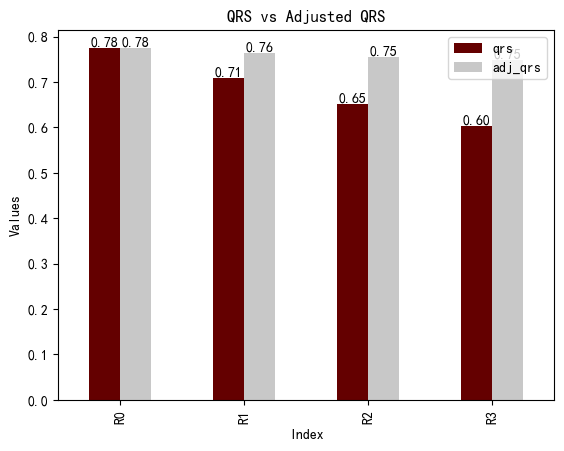

In [20]:
qrs_frame: pd.DataFrame = pd.DataFrame(columns=["qrs", "adj_qrs"])
for lag in [0, 1, 2, 3]:
    single_qrs: pd.DataFrame = qrs.fit(18, 600, n=lag)
    single_adj_qrs: pd.DataFrame = qrs.fit(18, 600, n=lag, adjust_regulation=True)
    qrs_frame.loc[f"R{lag:d}", "qrs"] = single_qrs["Signal"].abs().mean()
    qrs_frame.loc[f"R{lag:d}", "adj_qrs"] = single_adj_qrs["Signal"].abs().mean()

fig, ax = plt.subplots()
# 绘制条形图
bars_charts = qrs_frame.plot.bar(ax=ax,color=["#640000","#c8c8c8"])

# 添加 bar labels
for container in bars_charts.containers:
    ax.bar_label(container, fmt="%.2f")

# 设置图表标题和标签
ax.set_title("QRS vs Adjusted QRS")
ax.set_xlabel("Index")
ax.set_ylabel("Values")

In [21]:
multi_adj_regulation_dict: Dict = {}
for lag in [0, 1, 2, 3]:
    single_qrs: pd.DataFrame = qrs.fit(18, 600, n=lag, adjust_regulation=True)
    hs300_df["signal"] = single_qrs["Signal"]
    hs300_df["upperbound"] = 0.7
    hs300_df["lowerbound"] = -0.7

    multi_adj_regulation_dict[f"R{lag:d}"] = run_template_strategy(
        hs300_df,
        target_code,
        RSRSStrategy,
        strategy_kwargs={"verbose": False, "hold_num": 1},
    )

multi_strategy_show_trade_stats(multi_adj_regulation_dict)

2024-10-29 16:42:16.090 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:16.099 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！
2024-10-29 16:42:17.042 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:17.052 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！
2024-10-29 16:42:18.097 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:18.107 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！
2024-10-29 16:42:19.050 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:19.060 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！


,R0,R1,R2,R3
,Trade Stats,Trade Stats,Trade Stats,Trade Stats
Annual return,18.15%,18.36%,17.02%,16.27%
Sharpe ratio,1.01,1.02,0.95,0.91
Max drawdown,47.89%,47.89%,50.24%,51.14%
Trade Num,68,69,65,67
Win Rate,55.88%,59.42%,52.31%,55.22%
Win Loss Ratio,1.91,1.70,2.12,1.91


# 对信号项进行改造

在信号项中 𝑠𝑡𝑑(ℎ𝑖𝑔ℎ) 与 𝑠𝑡𝑑(𝑙𝑜𝑤) 明显是符合择时逻辑的关键部分，𝑠𝑡𝑑(ℎ𝑖𝑔ℎ) 可以 理解为阻力变量的波动，波动越大，说明投资者对阻力的分歧越大，阻力的强度越低； 同理 𝑠𝑡𝑑(𝑙𝑜𝑤) 则是支撑变量的波动，波动越大，说明支撑的强度越低。那么，在惩罚项起关键作用的 𝑐𝑜𝑟𝑟(ℎ𝑖𝑔ℎ, 𝑙𝑜𝑤) 在信息项中是否在信息项中也是必要成分？还是说可 以将其删去以精简指标公式？我们不妨测试下把其删去对择时能力带来的影响。


在全样本净值测试中，精简指标择时模型整体的净值走势与原始模型有些相似，也有较 显著的择时能力。在下表统计数据中，可以看出虽然在开仓胜率及最大回撤上稍有些改 善，但整体择时效果相比原始指标择时策略还是有明显下滑。年化收益从原始指标的 10.72% 降到 8.92%；夏普比率从 0.78 降至 0.6；平均盈亏比从 1.73 降至 1.29。

In [22]:
from src.plotting_utils import get_strategy_cumulative_return,get_strategy_return

In [23]:
target_code: str = "000300.SH"
fields: List[str] = ["code","open", "high", "low", "close", "volume"]
hs300_df: pd.DataFrame = daily.query("code==@target_code")[fields].copy()
hs300_df["upperbound"] = 0.7
hs300_df["lowerbound"] = -0.7
qrs: QRSCreator = QRSCreator(low_df[target_code], high_df[target_code])

In [24]:
params: Dict = {
    "simple_signal": True,
    "qrs": False,
}

multi_strategy_dict: Dict = {}

for name, p in params.items():
    signal_df = qrs.fit(18, 600, n=2, adjust_regulation=False, use_simple_beta=p)
    if name.find("simple") != -1:
        hs300_df["signal"] = qrs.zscore_simple_beta["Signal"]
    else:
        hs300_df["signal"] = qrs.zscore_beta["Signal"]

    multi_strategy_dict[name] = run_template_strategy(
        hs300_df.dropna(subset=["signal"]),
        target_code,
        RSRSStrategy,
        strategy_kwargs={"verbose": False, "hold_num": 1},
    )

2024-10-29 16:42:20.053 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:20.061 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！
2024-10-29 16:42:20.937 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:20.945 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！


In [25]:
cum_returns: pd.DataFrame = pd.concat(
    {
        name: get_strategy_cumulative_return(strat, 1)
        for name, strat in multi_strategy_dict.items()
    }
).unstack(level=0)
first_date: pd.Timestamp = hs300_df["signal"].first_valid_index()
cum_returns["benchmark"] = (
    hs300_df.loc[first_date:, "close"] / hs300_df["close"].loc[first_date]
)

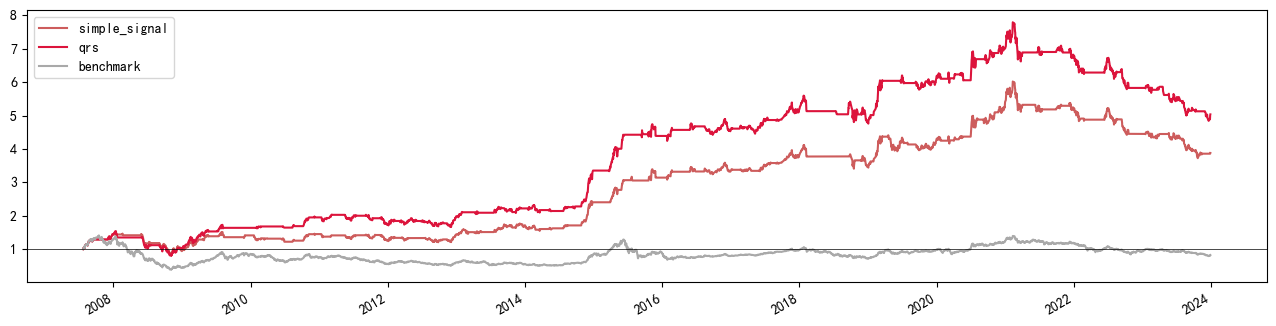

In [26]:
cum_returns.plot(color=["IndianRed", "Crimson", "darkgray"], figsize=(16, 4)).axhline(
    1, color="black", lw=0.5
)

In [27]:
multi_strategy_show_trade_stats(multi_strategy_dict)

,simple_signal,qrs
,Trade Stats,Trade Stats
Annual return,8.92%,10.72%
Sharpe ratio,0.60,0.70
Max drawdown,42.35%,47.87%
Trade Num,68,68
Win Rate,60.29%,55.88%
Win Loss Ratio,1.29,1.73


# 动态上下边界

研报中的开仓阈值设置S为0.7,大致是信号$\pm 1$标准差左右,如果边界设置为过去1年的标准差效果会怎样呢？如下可知，动态阈值年化为8.48%比固定阈值年化低1%左右,但回撤从固定阈值的50.21%降低到了动态阈值的39.30%左右。

In [28]:
target_code: str = "000300.SH"

qrs: QRSCreator = QRSCreator(low_df, high_df)
signal_df: pd.DataFrame = qrs.fit(18, 600, adjust_regulation=True)
ohlc_and_signal: pd.DataFrame = concat_ohlc_vs_signal(daily, signal_df)

dynamic_ul_dict: Dict = {}


def get_dynamic_bound_result(
    target_code: str, ohlc_and_signal: pd.DataFrame, window: int
):
    """
    根据给定的目标代码和OHLC数据，计算动态上下界并运行策略。

    :param target_code: 目标股票代码
    :type target_code: str
    :param ohlc_and_signal: 包含OHLC数据和信号的DataFrame
    :type ohlc_and_signal: pd.DataFrame
    :param window: 滚动窗口大小
    :type window: int
    :return: 策略运行结果
    :rtype: StrategyResult
    """
    df: pd.DataFrame = ohlc_and_signal.query("code==@target_code").copy()
    rolling_avg: pd.Series = df["signal"].rolling(window).mean()
    rolling_std: pd.Series = df["signal"].rolling(window).std()
    df["upperbound"] = rolling_avg + rolling_std
    df["lowerbound"] = rolling_avg - rolling_std

    strat = run_template_strategy(
        df.iloc[window-1:], target_code, RSRSStrategy, strategy_kwargs={"verbose": False, "hold_num": 1}
    )

    return strat


def get_fixed_bound_result(target_code: str, ohlc_and_signal: pd.DataFrame):
    """
    获取固定边界结果

    参数:
    target_code (str): 目标代码。
    ohlc_and_signal (pd.DataFrame): 包含OHLC数据和信号的DataFrame。

    返回:
    pd.DataFrame: 策略运行结果。
    """

    df: pd.DataFrame = ohlc_and_signal.query("code==@target_code").copy()
    df["upperbound"] = 0.7
    df["lowerbound"] = -0.7

    strat = run_template_strategy(
        df, target_code, RSRSStrategy, strategy_kwargs={"verbose": False, "hold_num": 1}
    )

    return strat


dynamic_ul_dict["fixed_bound"] = get_fixed_bound_result(target_code, ohlc_and_signal)
dynamic_ul_dict["dynamic_bound"] = get_dynamic_bound_result(
    target_code, ohlc_and_signal, 252
)

2024-10-29 16:42:22.451 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:22.460 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！
2024-10-29 16:42:22.878 | INFO     | backtrader_utils.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-10-29 16:42:22.888 | SUCCESS  | backtrader_utils.engine:load_data:134 - 数据加载完毕！


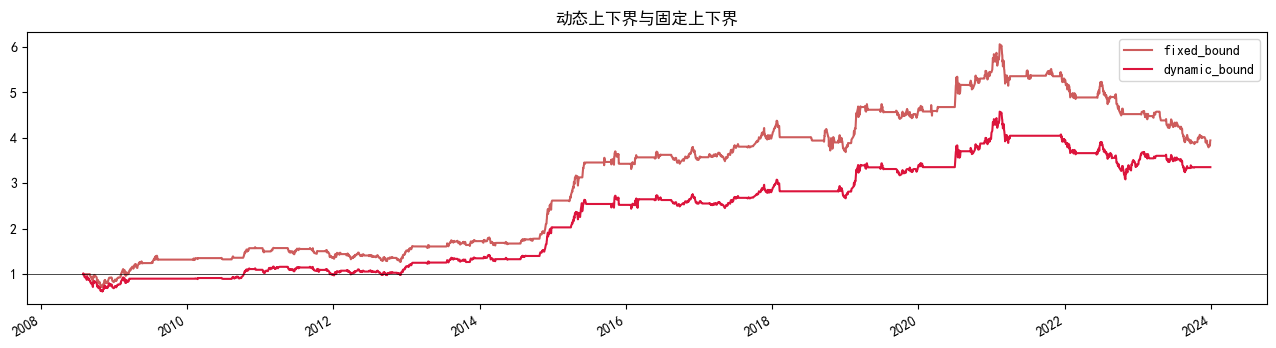

In [29]:
returns: pd.DataFrame = pd.concat(
    {name: get_strategy_return(start) for name, start in dynamic_ul_dict.items()}
).unstack(level=0)
returns: pd.DataFrame = returns.loc[returns["dynamic_bound"].first_valid_index() :]

ep.cum_returns(returns, 1).plot(
    figsize=(16, 4), color=["IndianRed", "Crimson"], title="动态上下界与固定上下界"
).axhline(1, color="black", lw=0.5)

In [30]:
multi_strategy_show_trade_stats(dynamic_ul_dict)

,fixed_bound,dynamic_bound
,Trade Stats,Trade Stats
Annual return,9.49%,8.48%
Sharpe ratio,0.63,0.59
Max drawdown,50.21%,39.30%
Trade Num,65,47
Win Rate,52.31%,46.81%
Win Loss Ratio,1.89,3.16
